In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import time
from pathlib import Path
import os
from tqdm.auto import tqdm
import copy


# Magic Function
%matplotlib inline

# Hide all warnings
import warnings
warnings.filterwarnings('ignore') # warnings.filterwarnings(action='once')

# monkey-patch torchvision to work offline or behind a firewall
from pathlib import Path
model_path = Path('../../data/processed/models/resnet18-5c106cde.pth').absolute().resolve()
models.resnet.model_urls['resnet18'] = 'file://{}'.format(model_path)
model_path = Path('../../data/processed/models/resnet34-333f7ec4.pth').absolute().resolve()
models.resnet.model_urls['resnet34'] = 'file://{}'.format(model_path)

# Finetuning / Transfer Learning

Finetuning or Transfer Learning in DNNs is done by taking a pretrained model and repurposed to a new dataset. The idea behind this approach is that pretrained datasets usually provide a better starting point for training than randomly initializing a network. Therefore, it is expected that the network can converge faster when doing finetuning.

It's also usefull when you don't have enougth data. Your networks can learn basic features like "edges" from a similar task that is rich with data. Then it can fine tune on your data.

Since real world commercial use cases often lack sufficient data, this is a common and valuable technique.

<div class="alert alert-info" style="font-size:100%">
    
**WARNING** <br/>
We recommend running this notebook only if you have a GPU available. The training code might take more than 40 minutes in a `cpu`.
</div>

Let's setup a device variable. This will allow us to automatically use a `gpu` if it is available. Otherwise, it will use `cpu`.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Now let's create a ResNet model using pretrained weights of the [ImageNet dataset](http://www.image-net.org/).

In [3]:
model_ft = models.resnet18(pretrained=True)

Now let's check the architecture of the ResNet model

In [4]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

As can be seen in the architecture, the last layer (fc) has an input size of 512. We can also get this information programatically using the code below:

In [5]:
# Input Features
num_ftrs = model_ft.fc.in_features
print(num_ftrs)

512


In the original ResNet arquitecture, the first layer (conv1) has 3 channels in the input. The reason for that is that it accepts colored images in the RGB space. However, our dataset only contains images in gray scale. Those images only have one channel so we need to modify this in our ResNet model.

In [6]:
model_ft.conv1 = nn.Conv2d(
    1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
)

Now we need to modify the last layer. We will change the output from 1000 to match the number of classes we have in the new dataset.

In [7]:
# nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

In [8]:
# Pass the model to GPU or CPU
model_ft = model_ft.to(device)
# Declare Loss Function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-4, momentum=0.9)
# Decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Dataset
 
LANDMASS is a set of classified 2d subimages extracted from the F3 seismic volume by researchers at Georgia Tech. LANDMASS-1, contains 17667 small “patches” of size 99×99 pixels. It includes 9385 Horizon patches, 5140 chaotic patches, 1251 Fault patches, and 1891 Salt Dome patches. The images in this database have values 0-255

In this notebook, we will be using the landmass dataset, which have been preprocessed already. In this dataset, we have images of 4 different types of landmass: 'Chaotic Horizon', 'Fault', 'Horizon', 'Salt Dome'.

We will finetuned a pretrained CNN to learn how to classify images of landmass into those 4 classes.

Credits to researchers at Georgia Tech, Agile Geoscience
Source https://dataunderground.org/dataset/landmass-f3
License: Creative Commons Attribution Share-Alike

#  Data Augmentation
It is a well-known fact that current Deep Neural Networks (DNNs) are data hungry. The more examples we have for our model the better it will generalise. However, in some cases, getting more images is not a viable option. Fortunately, we can use data augmentation or image transformations to generate more images.

In Pytorch, we can use `transforms` to achieve this. Given that we are using pretrained models on ImageNet, it is important to normalize the data using the same `mean` and `std` than the one used on ImageNet. [More Information](https://pytorch.org/docs/stable/torchvision/models.html). However, in our particular case, the images used will be gray scale so we will change the normalization to work accordingly.

Which transforms do we want to choose? The ones that we want the model to be robust to, and the ones that represent real shifts in the data.

`transforms.Compose` will allow us to apply a sequential pipeline of transformations to your Pytorch Tensors.

In the example below, `transforms.RandomResizedCrop(224)` will resize (224x224 pixels) and crop randomly an image. `transforms.RandomHorizontalFlip()` will flip horizontally some images at random. Finally, after those two transformations the image is converted to Pytorch Tensor and the normalized.

A gallery of many possible image augmentations can be found on the [imgaug](https://github.com/aleju/imgaug) website, and there are also techniques for timeseries.

In [9]:
data_transforms = {
    # For the data training dataset
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=1, contrast=1),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]
    ),
    # For the validation dataset
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]
    ),
}

In [10]:
# Let's import the Patches
from deep_ml_curriculum.data.landmass_f3 import LandmassF3PatchesMini, LandmassF3Patches
from deep_ml_curriculum.config import project_dir


# Note you can use LandmassF3Patches here instead, to use full sized images
landmassf3_train = LandmassF3PatchesMini(
    project_dir / "data/processed/landmass-f3",
    train=True,
    transform=data_transforms["train"],
)
landmassf3_test = LandmassF3PatchesMini(
    project_dir / "data/processed/landmass-f3",
    train=False,
    transform=data_transforms["val"],
)
print(landmassf3_train)
print(landmassf3_test)

Dataset LandmassF3PatchesMini
    Number of datapoints: 39750
    Root location: /media/wassname/Storage5/projects2/3ST/deep_ml_curriculum/data/processed/landmass-f3
    Split: Train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0, 2], contrast=[0, 2], saturation=None, hue=None)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset LandmassF3PatchesMini
    Number of datapoints: 13251
    Root location: /media/wassname/Storage5/projects2/3ST/deep_ml_curriculum/data/processed/landmass-f3
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [11]:
classes = landmassf3_train.classes
num_classes = len(classes)
print(classes)

['Chaotic Horizon', 'Fault', 'Horizon', 'Salt Dome']


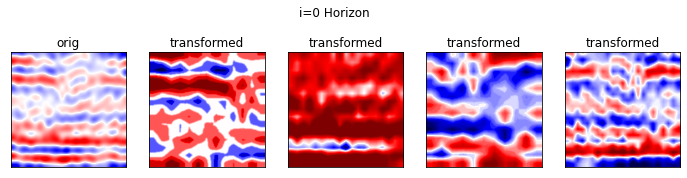

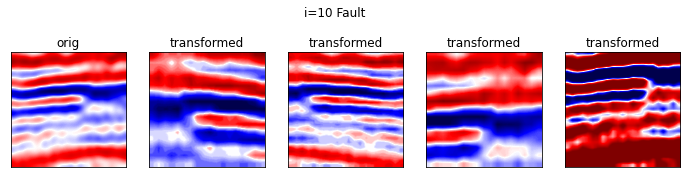

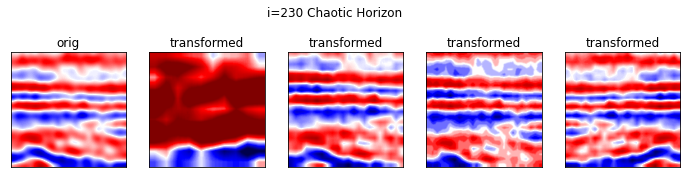

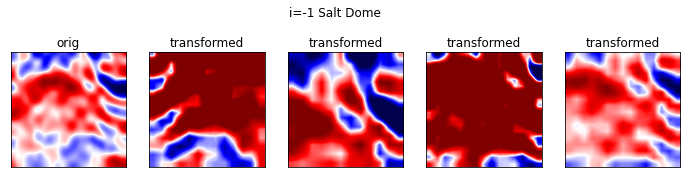

In [12]:
# lets look at how the data augmentation works
# The shows the same image along the row, the difference comes from data augmentation
for n in [0, 10, 230, -1]:
    # Make a figure
    plt.figure(figsize=(12,3))
    
    # on the first plot of 5
    plt.subplot(1, 5, 1)
    # show the original image
    orig_im = landmassf3_train.train_data[n].numpy()
    plt.imshow(orig_im, cmap='seismic', interpolation="bicubic")
    plt.xticks([])
    plt.yticks([])
    plt.title('orig')
    
    # On the next 4 images, show random transforms of the image
    for i in range(4):
        plt.subplot(1, 5, i+2)
        img, label = landmassf3_train[n]
        plt.title('transformed')
        plt.imshow(img.numpy()[0], cmap='seismic', interpolation="bicubic")
        plt.xticks([])
        plt.yticks([])
        
    # A title above all subplots
    plt.suptitle(f'i={n} {classes[label]}')
    plt.show()

# Train

In [13]:
# Parameters
params = {"batch_size": 64, "num_workers": 0, 'pin_memory':False}

In [14]:
dataloaders = {
    "train": DataLoader(landmassf3_train, shuffle=True, **params),
    "val": DataLoader(landmassf3_test, **params),
}

In [15]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    dataloader = None
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    def run_phase(model, phase, dataloader):
        """Run an epoch - through all the data once"""
        if phase == "train":
            model.train()  # Set model to training mode
        else:
            model.eval()  # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in tqdm(dataloader, desc=phase, leave=False):

            # print(inputs.shape, labels.shape)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == "train":
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if phase == "train":
            scheduler.step()

        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_corrects.double() / len(dataloader)
            
        return epoch_loss, epoch_acc


    try:
        # Test the initial accuracy before fine tuning
        epoch_loss, epoch_acc = run_phase(model, "val", dataloaders["val"])

        print('Original performance without finetuning')
        print("{} Loss: {:.4f} Acc: {:.4f}".format("Start", epoch_loss, epoch_acc))
        
        for epoch in tqdm(range(num_epochs), unit='epoch'):
            print("Epoch {}/{}".format(epoch, num_epochs - 1))
            print("-" * 10)



            # Each epoch has a training and validation phase
            for phase in ["train", "val"]:
                epoch_loss, epoch_acc = run_phase(model, phase, dataloaders[phase])
                print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

                # deep copy the model, this way we save the at the point with the best generalisation
                if phase == "val" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

            print()
    except KeyboardInterrupt:
        print(f"Stopped manually at epoch={epoch} phase={phase}")

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

<div class="alert alert-info" style="font-size:100%">
    
**WARNING** <br/>
The code below might take around 10 to 15 minutes to train on a cpu.
</div>

In [16]:
model_ft = train_model(
    model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2
)

Original performance without finetuning
Start Loss: 90.4178 Acc: 4.7644


Epoch 0/4
----------


train Loss: 61.2357 Acc: 38.9373


val Loss: 42.5557 Acc: 47.8173

Epoch 1/4
----------



Stopped manually at epoch=1 phase=train
Training complete in 2m 34s
Best val Acc: 47.817308


In [17]:
def visualize_model(model, num_images=8, figsize=(5,15)):
    """Show a grid of predictions"""
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=figsize)
    dataloader_val = dataloaders['val']
    

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader_val):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(
                    "predicted: {}\nTrue {}".format(dataloader_val.dataset.classes[preds[j]], dataloader_val.dataset.classes[labels[j]])
                )
                plt.imshow(
                    inputs.cpu().data[j].numpy()[0],
                    interpolation="bicubic",
                    cmap='seismic'
                )

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

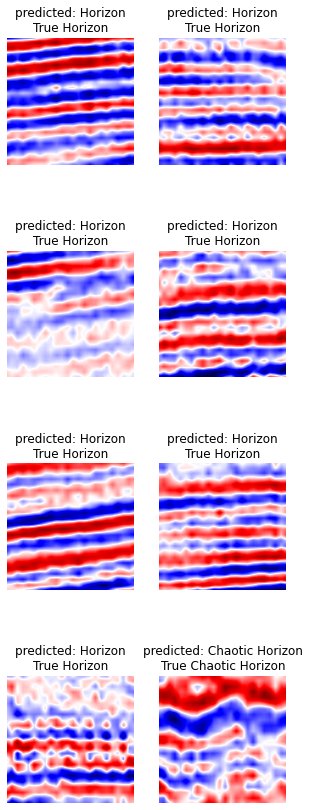

In [18]:
visualize_model(model_ft, num_images=8)

<div class="alert alert-success" style="font-size:100%">

**Exercise 1:** <br>
Repeat all the steps to apply transfer learning in a `Resnet34` model using the dataset `LandmassF3Patches`. Use `Adam` optimiser instead of `SGD`.
</div>


You can click in the button below the reveal the solution for exercise 1

<details>    
<summary>
    <font size="4" color="darkblue"><b>See the solution for Exercise 1</b></font>
</summary>
    
```python
from deep_ml_curriculum.data.landmass_f3 import LandmassF3Patches
from deep_ml_curriculum.config import project_dir

# Landmass 
landmassf3_train = LandmassF3Patches(project_dir / 'data/processed/landmass-f3', train=True, transform=data_transforms['train'])
landmassf3_test = LandmassF3Patches(project_dir / 'data/processed/landmass-f3', train=False, transform=data_transforms['val'])
# Modify Resnet34 for finetuning
model_ft = models.resnet34(pretrained=True)
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_ft.fc = nn.Linear(num_ftrs, 4)
model_ft = model_ft.to(device)
# Create Dataloader
dataloaders = {'train': DataLoader(landmassf3_train, **params),
               'val': DataLoader(landmassf3_test, **params)}

learning_rate = 1e-3
optimizer = torch.optim.Adam(model_ft.parameters(), lr=learning_rate)

# Train model
model_ft = train_model(model_ft, dataloaders, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25)
```

</details>

<div class="alert alert-success" style="font-size:100%">

**Exercise 2:** <br>
Repeat the above but this time train it from scratch, without the pretrain=True option. Without finetuning it should have poorer results.

</div>


You can click in the button below the reveal the solution for exercise 2

<details>    
<summary>
    <font size="4" color="darkblue"><b>See the solution for Exercise 2</b></font>
</summary>
    
```python
from deep_ml_curriculum.data.landmass_f3 import LandmassF3Patches
from deep_ml_curriculum.config import project_dir

# Landmass 
landmassf3_train = LandmassF3Patches(project_dir / 'data/processed/landmass-f3', train=True, transform=data_transforms['train'])
landmassf3_test = LandmassF3Patches(project_dir / 'data/processed/landmass-f3', train=False, transform=data_transforms['val'])
# Modify Resnet34 for finetuning
model_ft = models.resnet18(pretrained=False)
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_ft.fc = nn.Linear(num_ftrs, 4)
model_ft = model_ft.to(device)

# Create Dataloader
dataloaders = {'train': DataLoader(landmassf3_train, shuffle=True, **params),
               'val': DataLoader(landmassf3_test, **params)}

learning_rate = 1e-4
optimizer = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)

# Train model
model_ft = train_model(model_ft, dataloaders, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=2)

```

</details>


# Sources

[Finetuning Pytorch tutorial](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)